# Typical Weekday SARIMA — v5 (Simple Metrics)
**Created:** 2025-09-30 07:16 UTC

This notebook trains **weekday-specific** SARIMA models (Mon–Fri) with:
- **Baseline SARIMA(1,1,1)×(1,1,1,24)** only (no exogenous variables)
- **Robust fitting:** scaling, enforced stationarity/invertibility, optimizer fallbacks
- **Simple metrics:** RMSE and **Accuracy %** = `100 * (1 - MAE / mean(actual_validation))`
- Plots: validation actual vs forecast, last-month profiles, Month×Hour heatmaps

Outputs saved to `outputs/typical_weekday_v5/`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams.update({"figure.figsize": (8, 4), "axes.grid": False})

CSV_PATH = r"C:\Users\fletc\Documents\Uni\Capstone Project\Real Myki data\working CSV WHOLE DATA.csv"
ROUTE_FILTER: Optional[str] = None

MASK_OVERNIGHT = False
OVERNIGHT_HOURS = (1, 2, 3, 4)
FILL_MISSING_HOURS_WITH_ZERO = True

BUSINESS_HOURS_ONLY = False
BUSINESS_HOUR_RANGE = (5, 23)

OUTPUT_DIR = Path("outputs/typical_weekday_v5"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WEEKDAY_ORDER = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

print("Config ready.")

Config ready.


In [2]:
CSV_PATH = Path(CSV_PATH)
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"
df_raw = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "| shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
display(df_raw.head(10))

def _combine_year_month_to_period(year_series, month_series):
    s = year_series.astype(str).str.strip() + "-" + month_series.astype(str).str.strip() + "-01"
    dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    if dt.isna().any():
        month_map = {m.lower(): i for i, m in enumerate(
            ["January","February","March","April","May","June","July","August","September","October","November","December"], start=1)}
        def _to_mm(x):
            xs = str(x).strip()
            if xs.isdigit(): return xs.zfill(2)
            xlow = xs.lower()
            for full, num in month_map.items():
                if xlow.startswith(full[:3]):
                    return str(num).zfill(2)
            return xs
        s2 = year_series.astype(str).str.strip() + "-" + month_series.map(_to_mm).astype(str).str.strip() + "-01"
        dt = pd.to_datetime(s2, errors="coerce")
    if dt.isna().any():
        bad = df_raw.loc[dt.isna(), ["Year","Month"]].head(10)
        raise ValueError(f"Could not parse some Year/Month pairs. Examples:\n{bad}")
    return dt.dt.to_period("M")

def _to_weekday_name(x) -> str:
    xs = str(x).strip().lower()
    if xs.startswith("mon"): return "Monday"
    if xs.startswith("tue"): return "Tuesday"
    if xs.startswith("wed"): return "Wednesday"
    if xs.startswith("thu"): return "Thursday"
    if xs.startswith("fri"): return "Friday"
    if xs.startswith("sat"): return "Saturday"
    if xs.startswith("sun"): return "Sunday"
    return str(x).strip().title()

df = df_raw.copy()
df["month"] = _combine_year_month_to_period(df["Year"], df["Month"])
df["dow_name"] = df["Day of the Week"].apply(_to_weekday_name)
df["hour"] = pd.to_numeric(df["Hour"], errors="coerce").astype(int)
df["y"] = pd.to_numeric(df["Average Patronage"], errors="coerce").astype(float)
df["route"] = df["Route"].astype(str)

df = df[df["dow_name"].isin(WEEKDAY_ORDER)].copy()

if ROUTE_FILTER is not None:
    df = df[df["route"] == str(ROUTE_FILTER)].copy()
    if df.empty:
        raise ValueError(f"No rows for route == {ROUTE_FILTER!r}.")
else:
    df = (df.groupby(["month","dow_name","hour"], as_index=False)["y"].mean())
    df["route"] = "ALL"

df = df.sort_values(["dow_name","month","hour"]).reset_index(drop=True)
print("Prepared tidy data. Months:", df["month"].nunique(), "| Range:", str(df["month"].min()), "→", str(df["month"].max()))
display(df.head(10))

Loaded: C:\Users\fletc\Documents\Uni\Capstone Project\Real Myki data\working CSV WHOLE DATA.csv | shape: (10620, 6)
Columns: ['Year', 'Month', 'Route', 'Day of the Week', 'Hour', 'Average Patronage']


,Year,Month,Route,Day of the Week,Hour,Average Patronage
0,2024,7,200,Friday,6,37
1,2024,7,200,Friday,7,160
2,2024,7,200,Friday,8,262
3,2024,7,200,Friday,9,141
4,2024,7,200,Friday,10,161
5,2024,7,200,Friday,11,113
6,2024,7,200,Friday,12,156
7,2024,7,200,Friday,13,154
8,2024,7,200,Friday,14,157
9,2024,7,200,Friday,15,202


Prepared tidy data. Months: 12 | Range: 2024-07 → 2025-06


,month,dow_name,hour,y,route
0,2024-07,Friday,0,7.50,ALL
1,2024-07,Friday,1,7.00,ALL
2,2024-07,Friday,2,5.00,ALL
3,2024-07,Friday,3,4.00,ALL
4,2024-07,Friday,5,20.75,ALL
5,2024-07,Friday,6,43.00,ALL
6,2024-07,Friday,7,149.60,ALL
7,2024-07,Friday,8,200.50,ALL
8,2024-07,Friday,9,135.30,ALL
9,2024-07,Friday,10,121.00,ALL


In [3]:
def build_weekday_series(df_tidy: pd.DataFrame, weekday: str,
                           mask_overnight: bool = False,
                           overnight_hours: Tuple[int,...] = (1,2,3,4),
                           fill_missing_hours_with_zero: bool = True) -> pd.DataFrame:
    sub = df_tidy[df_tidy["dow_name"] == weekday].copy()
    if sub.empty:
        raise ValueError(f"No data for weekday {weekday!r}.")
    pivot = (sub.pivot_table(index="month", columns="hour", values="y", aggfunc="mean")
                .sort_index()
                .reindex(columns=list(range(24))))
    if fill_missing_hours_with_zero:
        pivot = pivot.fillna(0.0)
    if mask_overnight:
        for h in overnight_hours:
            if h in pivot.columns:
                pivot[h] = np.nan
    frame = pivot.stack().rename("y").reset_index()
    frame["t"] = np.arange(len(frame))
    return frame

def RMSE(a, f): return float(np.sqrt(np.nanmean((f - a)**2)))
def MAE(a, f):  return float(np.nanmean(np.abs(f - a)))
def ACCURACY_PERCENT(y_val, y_forecast):
    val_mean = float(np.nanmean(y_val))
    if not np.isfinite(val_mean) or val_mean == 0:
        return float('nan')
    return float(max(0.0, 100.0 * (1.0 - MAE(y_val, y_forecast) / val_mean)))

class Standardizer:
    def __init__(self, x):
        self.mean_ = float(np.nanmean(x))
        self.std_  = float(np.nanstd(x)) or 1.0
    def transform(self, x): return (x - self.mean_) / self.std_
    def inverse(self, z):   return z * self.std_ + self.mean_

def robust_fit_sarima(y_train_s):
    m = SARIMAX(y_train_s, order=(1,1,1), seasonal_order=(1,1,1,24),
                enforce_stationarity=True, enforce_invertibility=True)
    try:
        return m.fit(method="lbfgs", maxiter=2000, disp=False)
    except Exception:
        pass
    for meth in ("powell", "nm", "bfgs"):
        try:
            return m.fit(method=meth, maxiter=2000, disp=False)
        except Exception:
            continue
    return m.fit(disp=False)

print("Helpers ready.")

Helpers ready.


In [4]:
# ---- Metrics ----
metrics_rows = []
for wd in WEEKDAY_ORDER:
    frame = build_weekday_series(df, wd,
                                 mask_overnight=MASK_OVERNIGHT,
                                 overnight_hours=OVERNIGHT_HOURS,
                                 fill_missing_hours_with_zero=FILL_MISSING_HOURS_WITH_ZERO)
    y_all = frame["y"].to_numpy(float)
    t_all = frame["t"].to_numpy(int)

    if BUSINESS_HOURS_ONLY:
        lo, hi = BUSINESS_HOUR_RANGE
        keep = frame["hour"].between(lo, hi).to_numpy()
    else:
        keep = np.ones(len(frame), dtype=bool)

    yk = y_all[keep]; tk = t_all[keep]
    split = len(yk)//2
    y_tr, y_va = yk[:split], yk[split:]

    std = Standardizer(y_tr); y_tr_s = std.transform(y_tr)
    res = robust_fit_sarima(y_tr_s)
    f_va = std.inverse(np.asarray(res.get_forecast(steps=len(y_va)).predicted_mean))

    rmse = RMSE(y_va, f_va)
    acc  = ACCURACY_PERCENT(y_va, f_va)

    metrics_rows.append({
        "weekday": wd,
        "n_val": len(y_va),
        "RMSE": rmse,
        "Accuracy_%": acc,
        "business_hours_only": BUSINESS_HOURS_ONLY
    })

metrics_df = pd.DataFrame(metrics_rows)
metrics_dir = OUTPUT_DIR / "metrics"; metrics_dir.mkdir(parents=True, exist_ok=True)
metrics_path = metrics_dir / "weekday_metrics_v5.csv"
metrics_df.to_csv(metrics_path, index=False)

print("Saved metrics →", metrics_path)
display(metrics_df)

Saved metrics → outputs\typical_weekday_v5\metrics\weekday_metrics_v5.csv


,weekday,n_val,RMSE,Accuracy_%,business_hours_only
0,Monday,132,11.649579,90.047819,False
1,Tuesday,132,11.821018,91.668470,False
2,Wednesday,144,55.084580,48.307893,False
3,Thursday,144,24.855212,78.276160,False
4,Friday,144,16.261022,85.776424,False


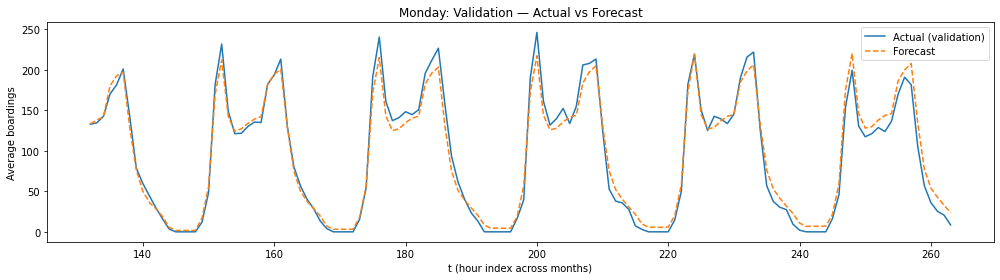

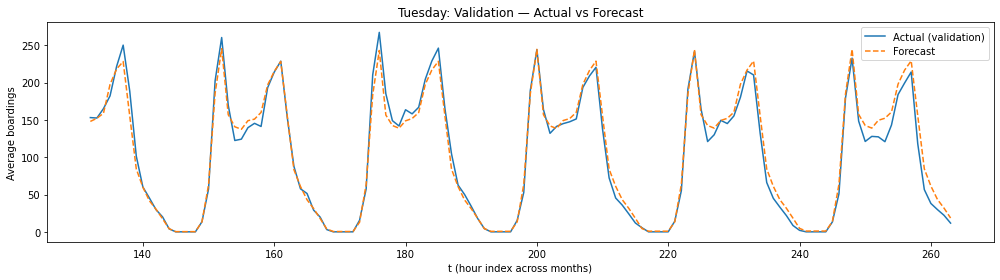

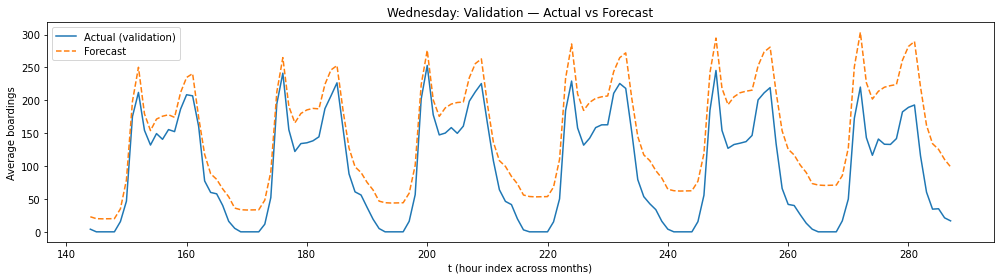

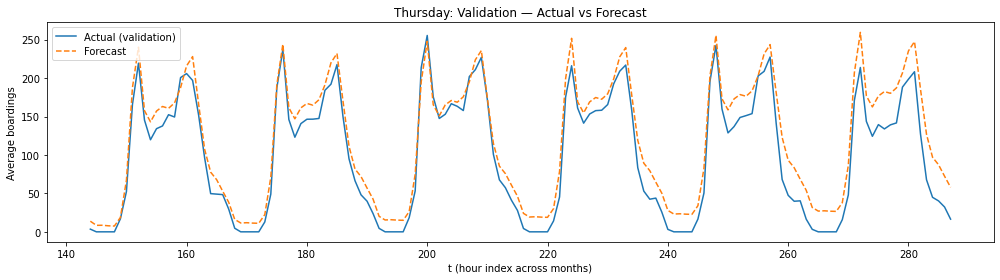

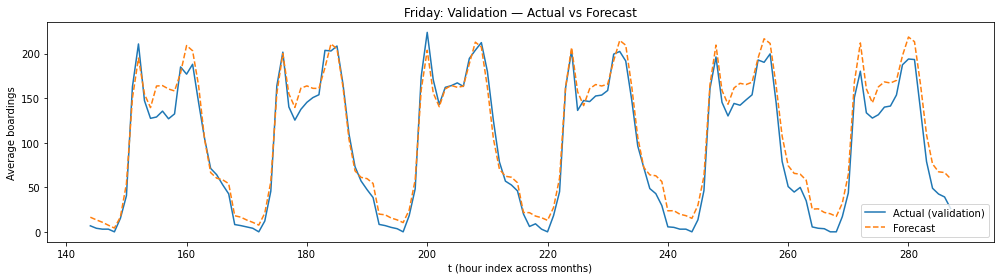

In [5]:
# ---- Validation plots ----
FIGS_DIR = OUTPUT_DIR / "figures"; FIGS_DIR.mkdir(parents=True, exist_ok=True)

for wd in WEEKDAY_ORDER:
    frame = build_weekday_series(df, wd,
                                 mask_overnight=MASK_OVERNIGHT,
                                 overnight_hours=OVERNIGHT_HOURS,
                                 fill_missing_hours_with_zero=FILL_MISSING_HOURS_WITH_ZERO)
    y_all = frame["y"].to_numpy(float); t_all = frame["t"].to_numpy(int)

    if BUSINESS_HOURS_ONLY:
        lo, hi = BUSINESS_HOUR_RANGE
        keep = frame["hour"].between(lo, hi).to_numpy()
    else:
        keep = np.ones(len(frame), dtype=bool)

    yk = y_all[keep]; tk = t_all[keep]
    split = len(yk)//2
    y_tr, y_va = yk[:split], yk[split:]
    t_va = tk[split:]

    std = Standardizer(y_tr); y_tr_s = std.transform(y_tr)
    res = robust_fit_sarima(y_tr_s)
    f_va = std.inverse(np.asarray(res.get_forecast(steps=len(y_va)).predicted_mean))

    plt.figure(figsize=(14,4))
    plt.plot(t_va, y_va, label="Actual (validation)")
    plt.plot(t_va, f_va, label="Forecast", linestyle="--")
    plt.title(f"{wd}: Validation — Actual vs Forecast")
    plt.xlabel("t (hour index across months)")
    plt.ylabel("Average boardings")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"{wd}_validation_v5.png", dpi=180)
    plt.show()

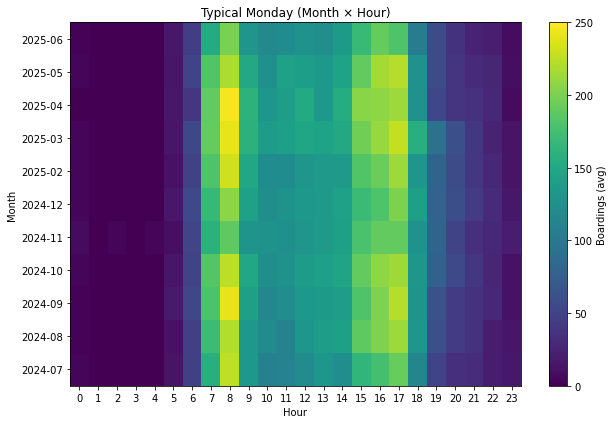

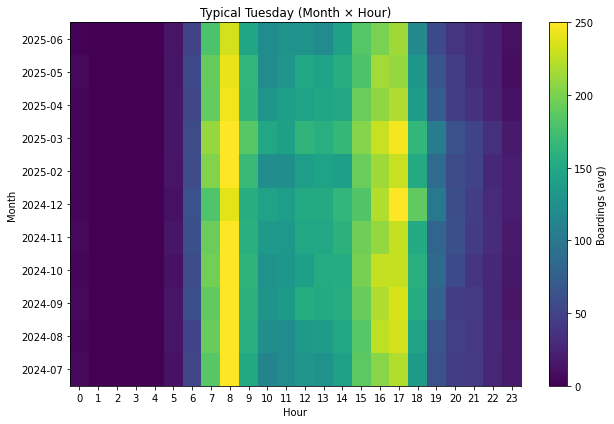

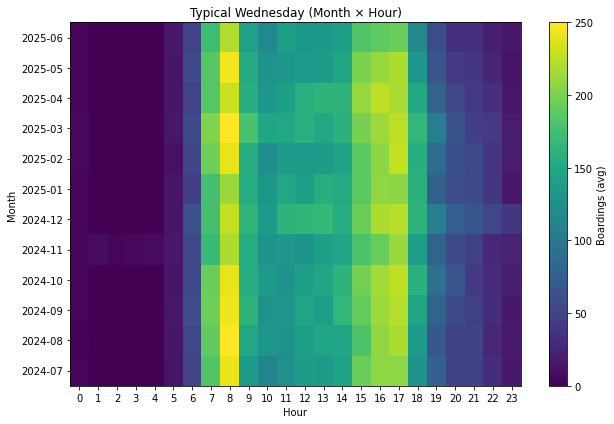

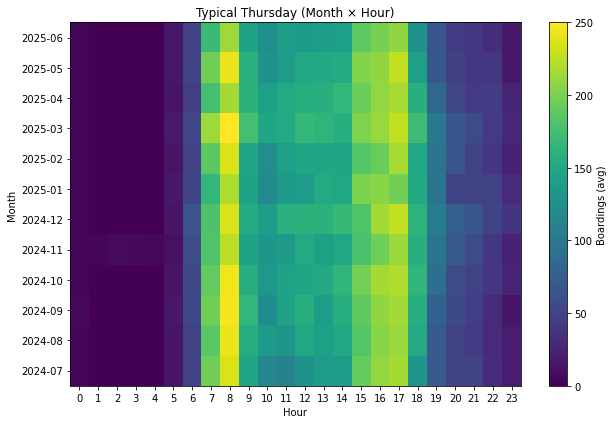

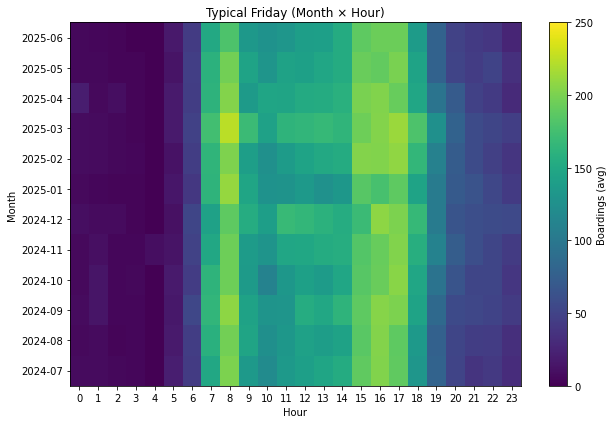

Frames saved → outputs\typical_weekday_v5\frames
Figures saved → outputs\typical_weekday_v5\figures


In [6]:
# ----heatmaps/save frames ----
FRAMES_DIR = OUTPUT_DIR / "frames"
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

for wd in WEEKDAY_ORDER:
    frame = build_weekday_series(
        df, wd,
        mask_overnight=MASK_OVERNIGHT,
        overnight_hours=OVERNIGHT_HOURS,
        fill_missing_hours_with_zero=FILL_MISSING_HOURS_WITH_ZERO
    )
    frame.to_csv(FRAMES_DIR / f"weekday_frame_{wd}.csv", index=False)

    y = frame["y"].to_numpy(float)
    std_full = Standardizer(y)
    y_s = std_full.transform(y)
    res_full = robust_fit_sarima(y_s)
    fitted = std_full.inverse(res_full.fittedvalues)
    

    # --- Month × Hour heatmap ---
    mat = frame.pivot(index="month", columns="hour", values="y").sort_index()
    plt.figure(figsize=(9, 6))
    plt.imshow(mat.values, aspect="auto", origin="lower", vmin=0, vmax=250)
    plt.yticks(ticks=np.arange(mat.shape[0]), labels=[str(m) for m in mat.index])
    plt.xticks(ticks=np.arange(24), labels=list(range(24)))
    plt.xlabel("Hour")
    plt.ylabel("Month")
    plt.title(f"Typical {wd} (Month × Hour)")
    cbar = plt.colorbar()
    cbar.set_label("Boardings (avg)")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"{wd}_heatmap_v5.png", dpi=180)
    plt.show()

print("Frames saved →", FRAMES_DIR)
print("Figures saved →", FIGS_DIR)
